[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zanussbaum/pitch2mocap/blob/master/train.ipynb)

In [1]:
import os

if not os.path.isdir('pitch2mocap'):    
    !git clone https://github.com/zanussbaum/pitch2mocap.git

%cd pitch2mocap 
!pip -q install boto3

Cloning into 'pitch2mocap'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 43 (delta 21), reused 29 (delta 9), pack-reused 0
Unpacking objects: 100% (43/43), 162.34 KiB | 1.27 MiB/s, done.
/Users/zachnussbaum/Documents/GitHub/pitch2mocap/pitch2mocap


In [83]:
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
import glob

from pix2pix import Pix2Pix
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!sh download.sh

In [2]:
source_imgs = sorted([file for file in glob.glob("source/source*.png")])
target_imgs = sorted([file for file in glob.glob("target/target*.png")])
all_imgs = list(zip(source_imgs, target_imgs))

In [3]:
PATH = ""
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [4]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  input_image = tf.cast(image, tf.float32)

  return input_image

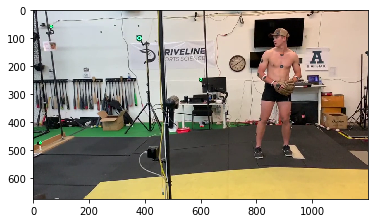

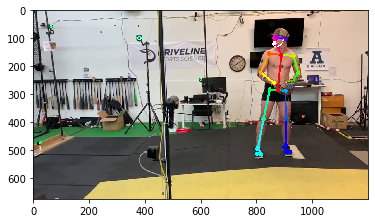

In [7]:
src = load(PATH + "source/source_100.png")
tar = load(PATH + "target/target_100.png")
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(src/255.0)
plt.figure()
plt.imshow(tar/255.0)

In [8]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [9]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [10]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [11]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [12]:
def load_image_train(image_file):
  input_file, target_file = image_file[0], image_file[1]
  input_image, target_image = load(input_file), load(target_file)

  input_image, target_image = random_jitter(input_image, target_image)
  input_image, target_image = normalize(input_image, target_image)

  return input_image, target_image

In [13]:
def load_image_test(image_file):
  input_file, target_file = image_file[0], image_file[1]
  input_image, target_image = load(input_file), load(target_file)

  input_image, target_image = resize(input_image, target_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, target_image = normalize(input_image, target_image)

  return input_image, target_image

In [14]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    plt.show()

In [15]:
train_val_dataset = tf.data.Dataset.from_tensor_slices(all_imgs)

split = 3
# we want to split the dataset into .75 train .25 val
train_dataset = train_val_dataset.window(split, split+1).flat_map(lambda ds: ds)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(int(BUFFER_SIZE*.75))
train_dataset = train_dataset.batch(BATCH_SIZE)

val_dataset = train_val_dataset.skip(split).window(1, split+1).flat_map(lambda ds: ds)
val_dataset = val_dataset.map(load_image_test)
val_dataset = val_dataset.batch(BATCH_SIZE)

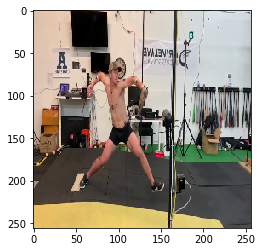

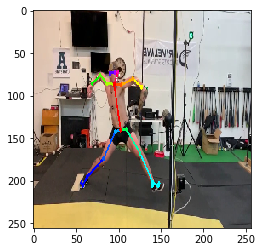

In [59]:
for t in train_dataset.take(1):
    plt.figure()
    plt.imshow((t[0][0]+1)*.5)
    plt.figure()
    plt.imshow((t[1][0]+1)*.5)

In [84]:
gan = Pix2Pix()

In [85]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [86]:
gan.compile(discriminator_optimizer, generator_optimizer, loss_object)

In [87]:
EPOCHS = 1
SIZE = int(len(all_imgs) * .75)

In [88]:
SIZE

533

In [89]:
%load_ext tensorboard
%tensorboard --logdir "logs/"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [90]:
gan.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)

     53/Unknown - 23s 430ms/step

KeyboardInterrupt: 

In [16]:
discrim, generator = squash_and_save_model(gan)


0026d33204f18d5377d82488596ce770.mp4 d2201c2ad010489fcce317e4be288c41.mp4
Hubbard mocap retest 20.1.28.mov     mocap1.mp4
